<a href="https://colab.research.google.com/github/thiagolermen/facemask-detection-v1/blob/main/FaceMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Face Mask Detection

Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. With this dataset, it is possible to create a model to detect people wearing mask or not wearing them..
This dataset contains 3824 images belonging to the 2 classes.
The classes are:

- With mask;
- Without mask;


##Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2
from keras.preprocessing.image import *
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

###Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###Path to Kaggle

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [4]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle/
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [5]:
!kaggle datasets download -d thiagolermen/dataset-face-mask-detection

 99% 126M/127M [00:04<00:00, 44.5MB/s]
100% 127M/127M [00:04<00:00, 33.2MB/s]


##Dataset

In [6]:
# Checking the file
!ls

CIFAR-10			 facemask-detection  midi-songs
dataset-face-mask-detection.zip  kaggle.json


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

In [8]:
import pathlib
# Root directory
dir = "/content/gdrive/My Drive/Kaggle/dataset/"


In [12]:
# Train data
train_dir = "/content/gdrive/My Drive/Kaggle/dataset/dataset/train/"
train_with_dir = "/content/gdrive/My Drive/Kaggle/dataset/dataset/train/with_mask/"
train_with_dir = pathlib.Path(train_with_dir)
train_without_dir = "/content/gdrive/My Drive/Kaggle/dataset/dataset/train/without_mask/"
train_without_dir = pathlib.Path(train_without_dir)

In [13]:
test_dir = "/content/gdrive/My Drive/Kaggle/dataset/dataset/test/"
test_with_dir = "/content/gdrive/My Drive/Kaggle/dataset/dataset/test/with_mask/"
test_with_dir = pathlib.Path(test_with_dir)
test_without_dir = "/content/gdrive/My Drive/Kaggle/dataset/dataset/test/without_mask/"
test_without_dir = pathlib.Path(test_without_dir)

Counting the number of files

In [14]:
mask_count_train = len(list(train_with_dir.glob('*.*')))
no_mask_count_train = len(list(train_without_dir.glob('*.*')))
mask_count_test = len(list(test_with_dir.glob('*.*')))
no_mask_count_test = len(list(test_without_dir.glob('*.*')))
print("Number of images in the training set:")
print(f"Number of images with mask: {mask_count_train} \nNumber of images without mask: {no_mask_count_train} \n")
print("Number of images in the test set:")
print(f"Number of images with mask: {mask_count_test} \nNumber of images without mask: {no_mask_count_test} \n")
print(f"Total number of images: {mask_count_train+no_mask_count_train+mask_count_test+no_mask_count_test}")


Number of images in the training set:
Number of images with mask: 1526 
Number of images without mask: 1538 

Number of images in the test set:
Number of images with mask: 380 
Number of images without mask: 380 

Total number of images: 3824


In [15]:
# Creating the number of categories

classes = ["with_mask", "without_mask"]

###Visualizing the dataset

In [17]:
def visualize_data(dir):
  plt.figure(figsize = (20 , 20))
  i=0
  count = 0
  for category in classes:
    path = os.path.join(dir, category)
    j=0
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path, img))
      plt.subplot(3, 3, count+1)
      plt.title(category)
      plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
      plt.show
      j = j+1
      count = count+1
      if j == 3:
        break
    i = i+1
    if i == 3:
      break

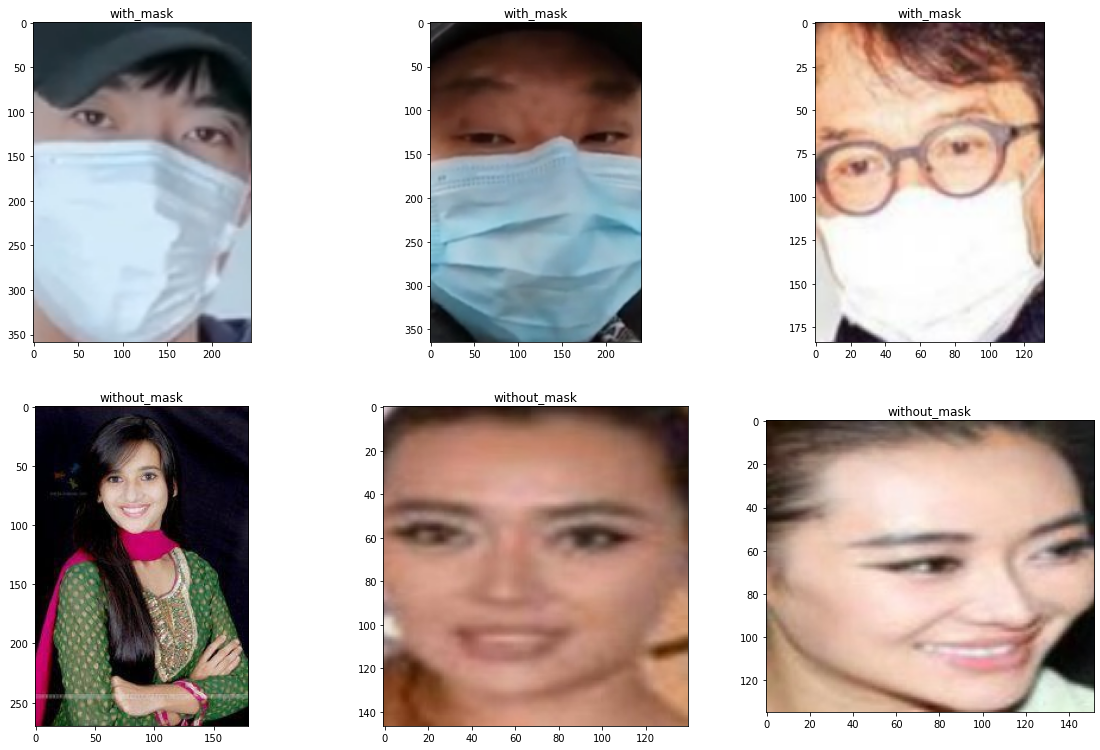

In [18]:
visualize_data(train_dir)

###Preprocessing data

We need to preprocess all the images. First of all we need to set a default image size (=224). We're going to use this size to match with the pretrained model which input is an image size (224,224,3)

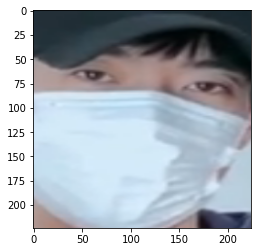

In [19]:
# Example with one image
img_size = 224
img = os.listdir(train_with_dir)[0]
img_array = cv2.imread(os.path.join(train_with_dir, img))
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))

####Augmentation

In [20]:
# Generate augmented data
datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    horizontal_flip  = True,
    rotation_range = 40,
    fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator(rescale = 1./255)

# For the training set
train_generator = datagen.flow_from_directory(
    train_dir,
    batch_size = 32,
    class_mode = 'binary',
    target_size = (224, 224)
)

# For the test set
test_generator = datagen.flow_from_directory(
    test_dir,
    batch_size = 32,
    class_mode = 'binary',
    target_size = (224, 224)
)

# For the cross validation set
valid_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size = 32,
    class_mode = 'binary',
    target_size = (224, 224)
)

Found 3064 images belonging to 2 classes.
Found 760 images belonging to 2 classes.
Found 760 images belonging to 2 classes.


In [21]:
print(f"Training data (batched) size: {len(train_generator)}")
print(f"Test data (batched) size: {len(test_generator)}")
print(f"CV data (batched) size: {len(valid_generator)}")

Training data (batched) size: 96
Test data (batched) size: 24
CV data (batched) size: 24


##Creating the model

Pretrained model:

In [22]:
model = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [23]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

####Fine tuning

In [24]:
base_input = model.layers[0].input # the model starts at the pretrained model's first layer

In [25]:
base_output = model.layers[-4].output # cuts at the pretraining model's dropout layer

In [26]:
flatten_layer = layers.Flatten()(base_input) # connect this layer with base_input
final_output = layers.Dense(1)(flatten_layer) # connect with flatten_layer
                                              # the model classifies in 1 or 0 (with or without mask)
final_output = layers.Activation('sigmoid')(final_output) # add an activation function to the dense layer

In [27]:
new_model = keras.Model(inputs = base_input, outputs=final_output)

In [28]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 150529    
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 150,529
Trainable params: 150,529
Non-trainable params: 0
_________________________________________________________________


##Compile the model

In [29]:
new_model.compile(loss = "binary_crossentropy", 
                  optimizer="adam",
                  metrics = ["accuracy"])

##Training the model

In [30]:
epochs = 20
history = new_model.fit(
    train_generator,
    batch_size = 32,
    epochs = epochs,
    validation_data = test_generator
)


Epoch 1/20
12/96 [==>...........................] - ETA: 45s - loss: 15.0133 - accuracy: 0.4625

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


96/96 [==============================] - 63s 655ms/step - loss: 5.6055 - accuracy: 0.6613 - val_loss: 1.2753 - val_accuracy: 0.7671
Epoch 2/20
96/96 [==============================] - 59s 611ms/step - loss: 0.7628 - accuracy: 0.8378 - val_loss: 0.8376 - val_accuracy: 0.8382
Epoch 3/20
96/96 [==============================] - 60s 629ms/step - loss: 0.6687 - accuracy: 0.8665 - val_loss: 0.7308 - val_accuracy: 0.8658
Epoch 4/20
96/96 [==============================] - 60s 626ms/step - loss: 0.8361 - accuracy: 0.8576 - val_loss: 1.0842 - val_accuracy: 0.8224
Epoch 5/20
96/96 [==============================] - 60s 629ms/step - loss: 0.8924 - accuracy: 0.8483 - val_loss: 1.9409 - val_accuracy: 0.7197
Epoch 6/20
96/96 [==============================] - 60s 620ms/step - loss: 0.7357 - accuracy: 0.8739 - val_loss: 1.1619 - val_accuracy: 0.8039
Epoch 7/20
96/96 [==============================] - 59s 619ms/step - loss: 0.9270 - accuracy: 0.8490 - val_loss: 0.9048 - val_accuracy: 0.8474
Epoch 8/20

Save the model

In [31]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
new_model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [32]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	saved_model.pb	variables


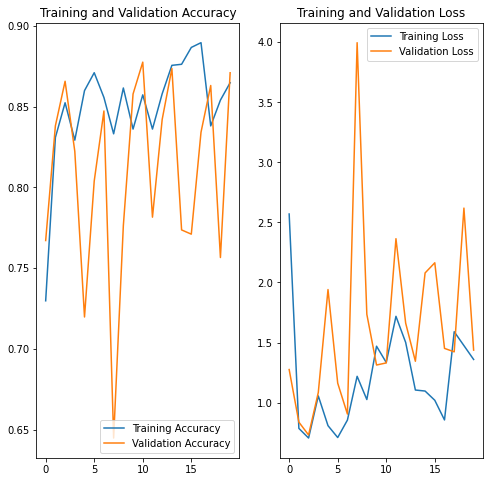

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Predictions

Loading the model

In [34]:
my_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
my_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 150529    
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 150,529
Trainable params: 150,529
Non-trainable params: 0
_________________________________________________________________


Evaluating the model

In [35]:
# Evaluate the restored model
loss, acc = my_model.evaluate(test_generator, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(test_generator).shape)

24/24 - 10s - loss: 1.5840 - accuracy: 0.8566
Restored model, accuracy: 85.66%
(760, 1)


We're going to use [Haar Cascade Face Detection](https://github.com/opencv/opencv/tree/master/data/haarcascades) by OpenCV

In [36]:
def face_detection(path):
  image = cv2.imread(path)
  faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = faceCascade.detectMultiScale(image_gray, 1.1, 4)
  for x,y,w,h in faces:
    only_face_gray = image_gray[y:y+h, x:x+w]
    only_face = image[y:y+h, x:x+w]
    cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,255), 2)
    facess = faceCascade.detectMultiScale(only_face_gray)
    if len(facess) == 0:
      print("Face not detected!")
    else:
      for (ex,ey,ew,eh) in facess:
        cropped_face = only_face[ey:ey+eh, ex:ex+ew]

        final_image = cv2.resize(cropped_face, (224,224))
        final_image = np.expand_dims(final_image, axis=0)
        final_image = final_image/255.0

        prediction = my_model.predict(final_image)
        if prediction[0][0] > 0.5:
          print("With mask")
          text = "mask"
        else:
          print("Without mask")
          text = "no mask"
        
        # Plot two images
        font = cv2.FONT_HERSHEY_PLAIN 
        cv2.putText(cropped_face, text, (ex, ey+10), font, 0.7, color=(0, 255, 255), thickness=1)

        plt.figure(figsize = (10,10))

        plt.subplot(1,2,1)
        plt.title('Full image')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        plt.subplot(1,2,2)
        plt.title('face_only')
        cropped_face = cv2.resize(cropped_face, (224,224))
        plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))


Face not detected!
With mask
With mask


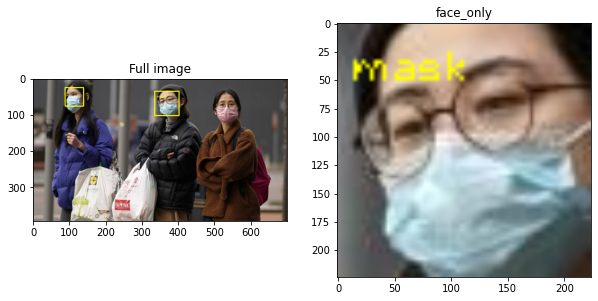

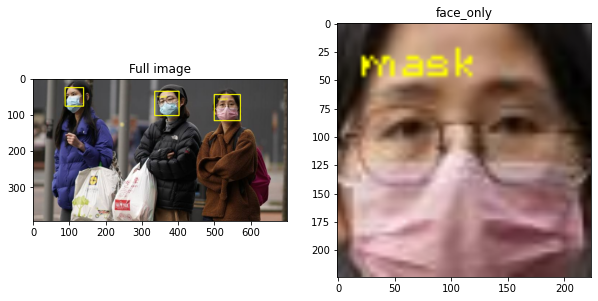

In [38]:
face_detection('/content/gdrive/My Drive/Kaggle/dataset/test1.jpg')

With mask


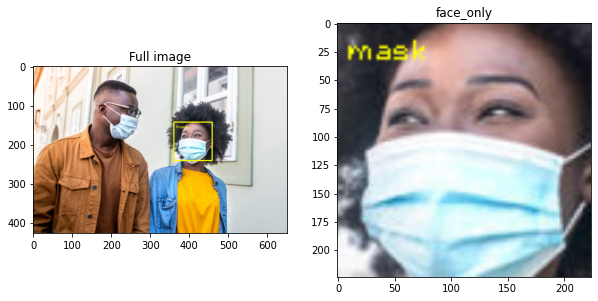

In [39]:
face_detection('/content/gdrive/My Drive/Kaggle/dataset/test2.jpg')

Without mask
Without mask
Face not detected!
With mask
Without mask
Without mask
With mask
Without mask
Without mask
With mask
Without mask
Without mask
Without mask


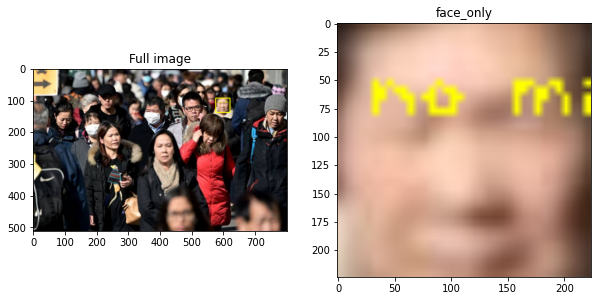

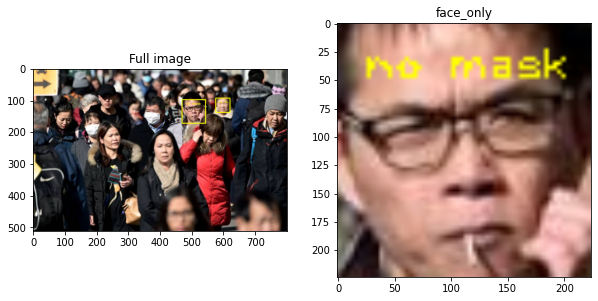

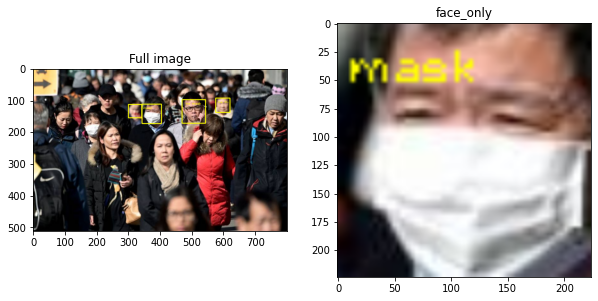

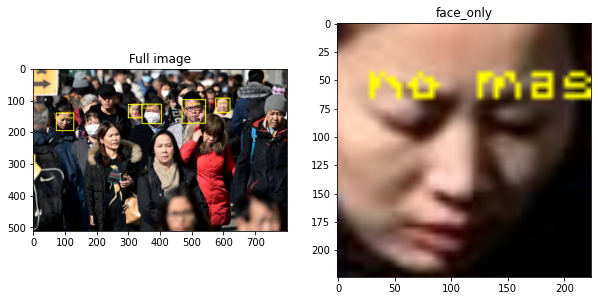

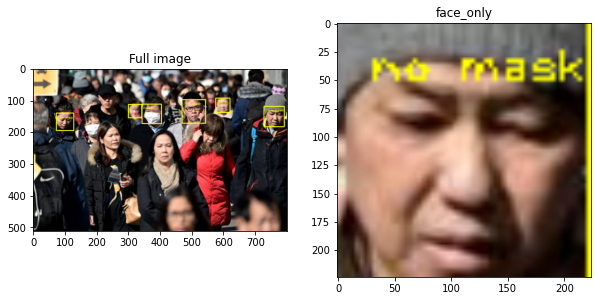

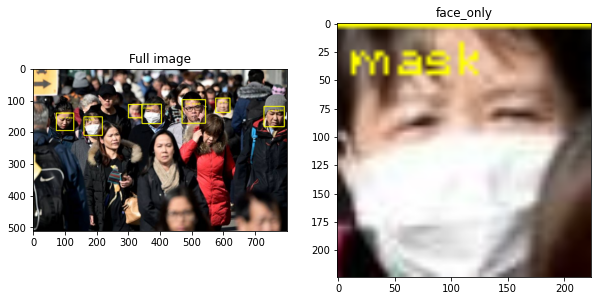

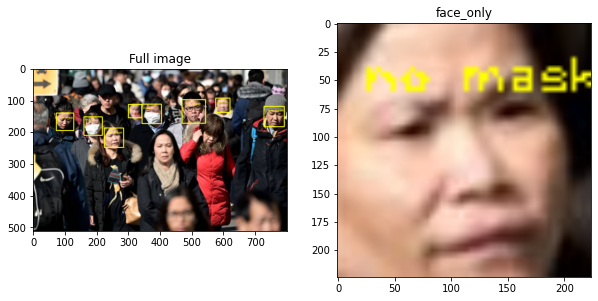

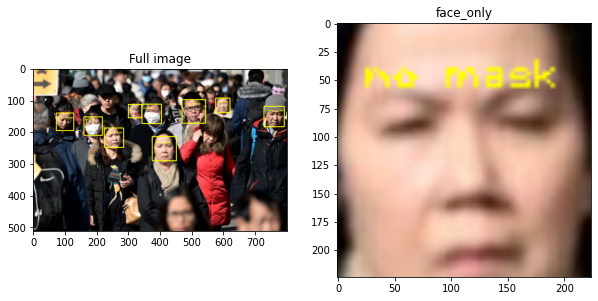

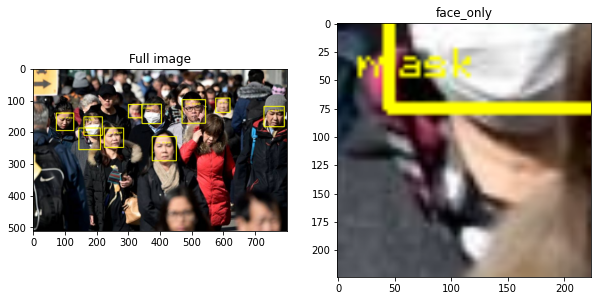

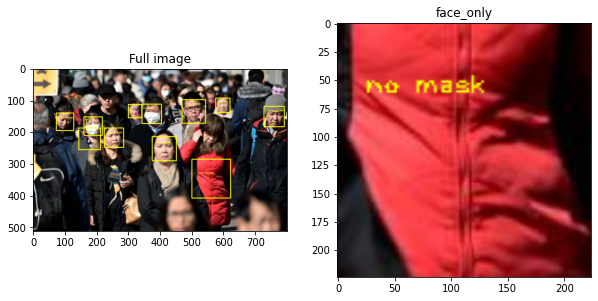

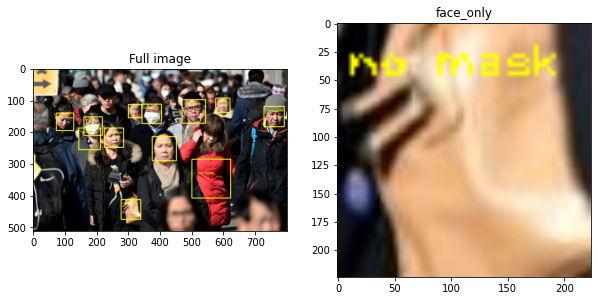

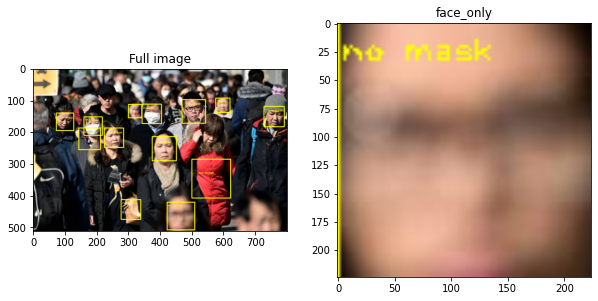

In [40]:
face_detection('/content/gdrive/My Drive/Kaggle/dataset/test3.jpg')

Face not detected!
With mask
With mask
Face not detected!
With mask


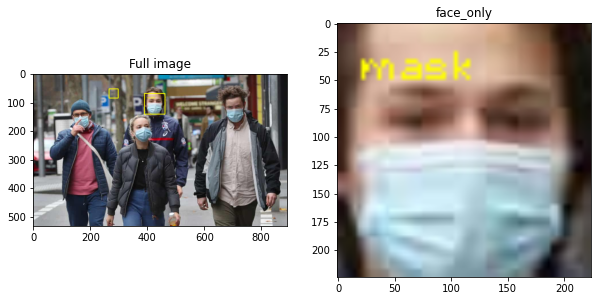

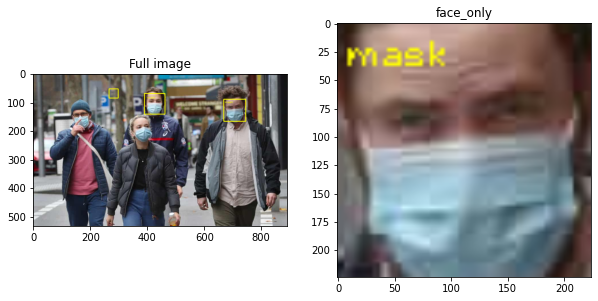

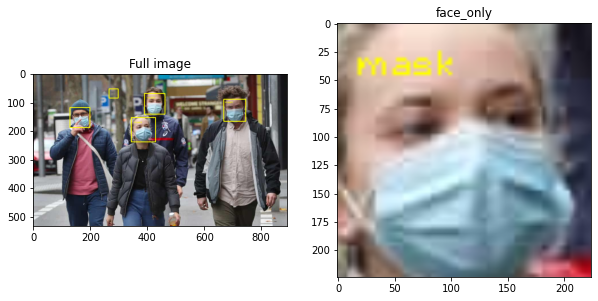

In [ ]:
face_detection('/content/gdrive/My Drive/Kaggle/dataset/test4.jpg')

On the next test, we can see, our algorithm to face detection can't recognize faces that are horizontally positioned.

With mask
With mask


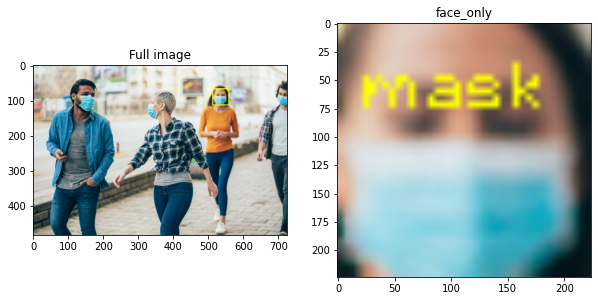

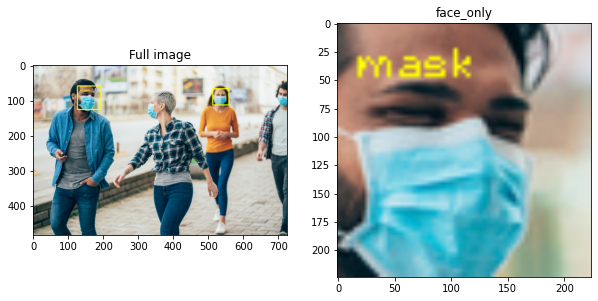

In [41]:
face_detection('/content/gdrive/My Drive/Kaggle/dataset/test5.jpg')